In [130]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as mp

In [131]:
class neuralNetwork:

    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        #кол-во узлов в входном слое
        self.inodes = inputnodes
        #кол-во узлов в скрытом слое
        self.hnodes = hiddennodes
        #кол-во узлов в выходном слое
        self.onodes = outputnodes
        
        #весовые коэф-ты от входного слоя к скрытому
        self.wih = (np.random.rand(self.hnodes, self.inodes) - 0.5)
        #весовые коэф-ты от скрытого слоя к выходному
        self.who = (np.random.rand(self.onodes, self.hnodes) - 0.5)

        #коэф. обучения сети
        self.lr = learningrate
        #запись сигмоиды в качестве анонимной функции
        self.activation_func = lambda x: sc.special.expit(x)
        pass

    def train(self, inputs_list, target_list):
        #входные сигналы в виде массива с последующим транспонированием (чтобы можно было производить расчеты)
        inputs = np.array(inputs_list, ndmin=2).T
        #целевые значения в виде массива с последующим транспонированием (чтобы можно было производить расчеты)
        #нужны для расчета обратного распространения ошибки
        targets = np.array(target_list, ndmin=2).T
        #произведение матрицы весовых коэф. между входным и скрытым слоями с входными сигналами
        hidden_inputs = np.dot(self.wih, inputs)
        #использование функции активации к сигналам скрытого слоя, для приведения к диапазону от 0.1 до 0.99
        hidden_outputs = self.activation_func(hidden_inputs)
        #произведение матрицы весовых коэф. между скрытым и выходными слоями с сигналами скрытого слоя
        final_inputs = np.dot(self.who, hidden_outputs)
        #использование функции активации к сигналам выходного слоя, для приведения к диапазону от 0.1 до 0.99
        final_outputs = self.activation_func(final_inputs)
        #расчет ошибки (целевое значение - выходные сигналы)
        output_errors = targets - final_outputs
        #расчет ошибок для каждого узла скрытого слоя
        #путем произведение транспонированной матрицы весовых коэф. между скрытым и выходным слоями с выходной ошибкой
        hidden_errors = np.dot(self.who.T, output_errors)
        #простановка новых весовых коэф. между скрытым и выходным слоями
        #с использованием расчитанной ошибки
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        #простановка новых весовых коэф. между скрытым и входным слоями
        #с использованием расчитанной ошибки 
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1 - hidden_outputs)), np.transpose(inputs))
        pass

    def query(self, inputs_list):
        #представление массива (одномерной матрицы) входных сигналов в вектор (т.е. транспонирование матрицы 1х3 на 3х1)
        inputs = np.array(inputs_list, ndmin = 2).T
        #вычисление сигналов, приходящих на скрытый слой до применение сигмоиды
        hidden_inputs = np.dot(self.wih, inputs)
        #применение сигмоиды
        hidden_outputs = self.activation_func(hidden_inputs)
        #вычисление сигналов, приходящих на выходной слой до применение сигмоиды
        final_inputs = np.dot(self.who, hidden_outputs)
        #применение сигмоиды
        final_outputs = self.activation_func(final_inputs)
        return final_outputs

In [132]:
#кол-во узлов в входном слое. в узел передается значение оттенка черного в пикселе
#кол-во узлов рассчитывается из произведения ширины и высоты картинки 28*28
input_nodes = 784;
hidden_nodes = 100;
#кол-во узлов в выходном слое. равно кол-ву определяемых цифр
output_nodes = 10;
effectivity = []
for lr in np.arange(0.1, 1, 0.1):
    learning_rate = lr
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
    #открытие файла. "r" - открыть только для чтения
    #в data_file записывается указатель файл. следующие обращения к файлу будут через данный указатель 
    data_file = open("dataset/mnist_train.csv", "r")
    #чтение всех строк в файле
    data_list = data_file.readlines()
    #закрытие файла во избежание конкурентности (одновременное использование одного файла несколькими командами)
    data_file.close()
    epochs = 1
    for e in range(epochs):
        for record in data_list:
            all_values = record.split(',')
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99
            n.train(inputs, targets)
            pass
        pass
    test_dataset_file = open("dataset/mnist_test.csv", "r")
    test_dataset_list = test_dataset_file.readlines()
    test_dataset_file.close()
    scorecard = []

    for record in test_dataset_list:
        all_values = record.split(',')
        correct_value = int(all_values[0])
        inputs = (np.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
        outputs = n.query(inputs)
        label = np.argmax(outputs)
        if(label == correct_value):
            scorecard.append(1)
            pass
        else:
            scorecard.append(0)
            pass
        pass
    scorecard_array = np.asarray(scorecard)
    #записываю в массив пару [коэф. скорости обучения, эффективность обучения] для выбора оптимального коэф-а обучения
    effectivity.append([lr, sum(scorecard)/len(scorecard)])
print(effectivity)

[[0.1, 0.9514], [0.2, 0.95], [0.30000000000000004, 0.9452], [0.4, 0.9424], [0.5, 0.9281], [0.6, 0.8996], [0.7000000000000001, 0.9015], [0.8, 0.8583], [0.9, 0.8482]]


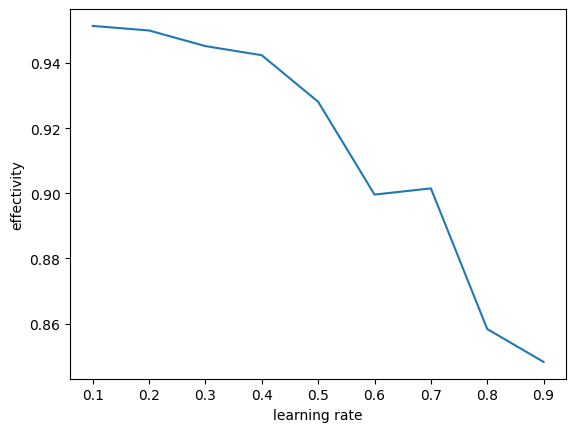

In [133]:
data_for_graphic = [[],[]];
for val in effectivity:
    data_for_graphic[0].append(val[0])
    data_for_graphic[1].append(val[1])
mp.figure()
mp.plot(data_for_graphic[0], data_for_graphic[1])
mp.xlabel("learning rate")
mp.ylabel("effectivity")
mp.show()